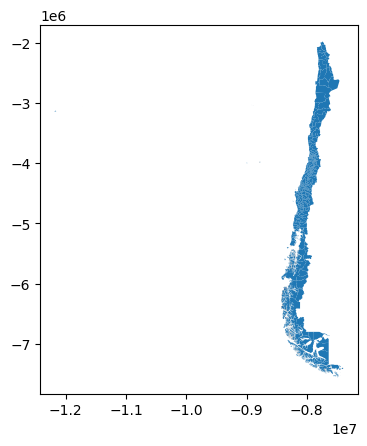

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file("/Users/dayth/OneDrive/Escritorio/Proyectos/EDA + ML/data/external/shapefiles/archivoscomunaschile/comunas.shx")

gdf.plot()
plt.show()

In [2]:
print(gdf.columns)
print(gdf.head())

Index(['objectid', 'shape_leng', 'dis_elec', 'cir_sena', 'cod_comuna',
       'codregion', 'st_area_sh', 'st_length_', 'Region', 'Comuna',
       'Provincia', 'geometry'],
      dtype='object')
   objectid     shape_leng  dis_elec  cir_sena  cod_comuna  codregion  \
0        48  170038.624165        16         8        6204          6   
1        29  125730.104795        15         8        6102          6   
2        30   63026.084422        15         8        6103          6   
3        31   89840.903562        15         8        6104          6   
4        78  122626.493264        23        11        9121          9   

     st_area_sh     st_length_                                    Region  \
0  9.685774e+08  206184.271675  Región del Libertador Bernardo O'Higgins   
1  4.157446e+08  151911.576827  Región del Libertador Bernardo O'Higgins   
2  1.448565e+08   76355.326122  Región del Libertador Bernardo O'Higgins   
3  3.256572e+08  108874.623150  Región del Libertador Bernardo 

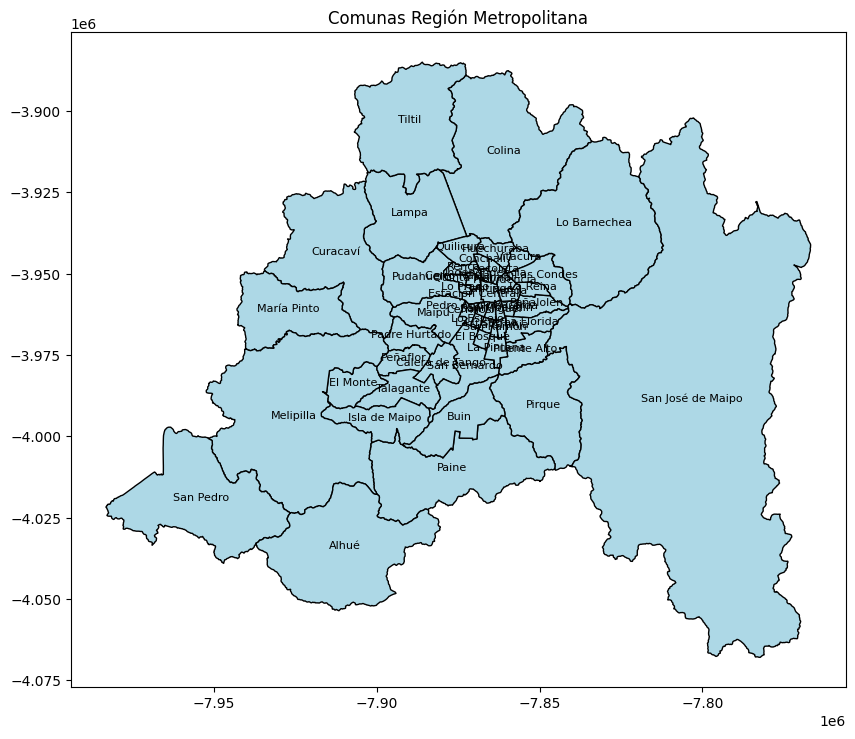

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

ruta_shp = "/Users/dayth/OneDrive/Escritorio/Proyectos/EDA + ML/data/external/shapefiles/archivoscomunaschile/comunas.shp"
gdf = gpd.read_file(ruta_shp)

rm = gdf[gdf['Region'] == "Región Metropolitana de Santiago"]

ax = rm.plot(edgecolor='black', facecolor='lightblue', figsize=(10,10))
plt.title("Comunas Región Metropolitana")

for idx, row in rm.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    plt.text(x, y, row['Comuna'], fontsize=8, ha='center')

plt.show()


In [5]:
print(rm.crs)

EPSG:3857


In [6]:
rm = rm.to_crs(epsg=4326)
print(rm.crs)


EPSG:4326


In [7]:
from shapely.geometry import Point
import geopandas as gpd

gdf = gpd.read_file("/Users/dayth/OneDrive/Escritorio/Proyectos/EDA + ML/data/external/shapefiles/archivoscomunaschile/comunas.shp")
rm = gdf[gdf['Region'] == "Región Metropolitana de Santiago"]

rm = rm.to_crs(epsg=4326)

def comuna_de_punto(lat, lon, gdf_rm):
    punto = Point(lon, lat)
    comuna = gdf_rm[gdf_rm.contains(punto)]
    if not comuna.empty:
        return comuna.iloc[0]['Comuna']
    else:
        return None

lat, lon = -33.826207, -70.063461

nombre_comuna = comuna_de_punto(lat, lon, rm)
print(nombre_comuna or "No pertenece a ninguna comuna de la RM")


San José de Maipo


In [8]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import numpy as np

def comuna_de_punto(lat, lon, gdf_rm):
    """
    Encuentra la comuna correspondiente a un punto dado por latitud y longitud
    """
    if pd.isna(lat) or pd.isna(lon):
        return None

    try:
        punto = Point(lon, lat)
        comuna = gdf_rm[gdf_rm.contains(punto)]
        if not comuna.empty:
            return comuna.iloc[0]['Comuna']
        else:
            return None
    except Exception as e:
        print(f"Error procesando coordenadas ({lat}, {lon}): {e}")
        return None

print("Cargando CSV...")
df = pd.read_csv("/Users/dayth/OneDrive/Escritorio/Proyectos/EDA + ML/interim/datos_scraping_unificados.csv")
print(f"Registros cargados: {len(df)}")

if 'latitud' not in df.columns or 'longitud' not in df.columns:
    print("Error: El CSV debe contener las columnas 'latitud' y 'longitud'")
    print(f"Columnas disponibles: {list(df.columns)}")
else:
    print(f"Coordenadas válidas: {df[['latitud', 'longitud']].notna().all(axis=1).sum()}")
    print(f"Coordenadas con valores nulos: {df[['latitud', 'longitud']].isna().any(axis=1).sum()}")

    print("Procesando coordenadas para obtener comunas...")
    df['comuna'] = df.apply(lambda row: comuna_de_punto(row['latitud'], row['longitud'], rm), axis=1)

    comunas_encontradas = df['comuna'].notna().sum()
    comunas_no_encontradas = df['comuna'].isna().sum()

    print(f"\nResultados:")
    print(f"Comunas encontradas: {comunas_encontradas}")
    print(f"Coordenadas sin comuna asignada: {comunas_no_encontradas}")

    if comunas_encontradas > 0:
        print(f"\nDistribución por comuna:")
        print(df['comuna'].value_counts().head(10))

    output_file = "/Users/dayth/OneDrive/Escritorio/Proyectos/EDA + ML/interim/propiedades_con_comuna.csv"
    df.to_csv(output_file, index=False)
    print(f"\nArchivo guardado como: {output_file}")

    print(f"\nPrimeras 5 filas con comuna asignada:")
    filas_con_comuna = df[df['comuna'].notna()].head()
    if not filas_con_comuna.empty:
        print(filas_con_comuna[['latitud', 'longitud', 'comuna']])
    else:
        print("No se encontraron coordenadas que correspondan a comunas de la RM")

Cargando CSV...
Registros cargados: 5970
Coordenadas válidas: 5957
Coordenadas con valores nulos: 13
Procesando coordenadas para obtener comunas...

Resultados:
Comunas encontradas: 5950
Coordenadas sin comuna asignada: 20

Distribución por comuna:
comuna
Puente Alto     621
Maipú           567
La Florida      455
Colina          301
San Bernardo    250
Las Condes      243
Peñalolén       231
Quilicura       182
Ñuñoa           166
Pudahuel        165
Name: count, dtype: int64

Archivo guardado como: /Users/dayth/OneDrive/Escritorio/Proyectos/EDA + ML/interim/propiedades_con_comuna.csv

Primeras 5 filas con comuna asignada:
     latitud   longitud        comuna
0 -33.345468 -70.678398    Huechuraba
1 -33.563160 -70.776609         Maipú
2 -33.563025 -70.559425   Puente Alto
3 -33.641678 -70.689872  San Bernardo
4 -33.613778 -70.887450      Peñaflor


In [9]:
df.head()

precio  banos  dormitorios  superficie_total  superficie_construida  \
0  322633576.0    3.0          5.0             404.0                  275.0   
1  124089837.0    3.0          3.0             102.0                   27.0   
2  157180460.0    2.0          3.0             190.0                  127.0   
3  133544301.0    2.0          5.0             146.0                   61.0   
4  117786861.0    2.0          3.0             145.0                   82.0   

   estacionamiento    latitud   longitud        comuna  
0              1.0 -33.345468 -70.678398    Huechuraba  
1              1.0 -33.563160 -70.776609         Maipú  
2              1.0 -33.563025 -70.559425   Puente Alto  
3              1.0 -33.641678 -70.689872  San Bernardo  
4              1.0 -33.613778 -70.887450      Peñaflor